# Smoothing models for time series forecasting

In [1]:

from modules import utils
utils.configure_plotly_template(showlegend=True)

## Load data

In [2]:
path = '../../../data/statsmodels/AirPassengers.parquet'

In [3]:
import pandas as pd

df = pd.read_parquet(path).asfreq('ME')
df.columns = ["values"]
series = df["values"]

series

1949-01-31    112
1949-02-28    118
             ... 
1960-11-30    390
1960-12-31    432
Freq: ME, Name: values, Length: 144, dtype: int64

## Model fit

In [4]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(df['values'], trend="add", seasonal="mul", seasonal_periods=12).fit()
model.summary()

Dep. Variable:,values,No. Observations:,144
Model:,ExponentialSmoothing,SSE,15952.883
Optimized:,True,AIC,709.892
Trend:,Additive,BIC,757.409
Seasonal:,Multiplicative,AICC,715.364
Seasonal Periods:,12,Date:,"Tue, 27 May 2025"
Box-Cox:,False,Time:,22:37:32
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3186214,alpha,True
smoothing_trend,7.318e-08,beta,True


## Forecast

In [5]:
forecast = model.forecast(steps=48)
forecast

1961-01-31    445.241470
1961-02-28    418.224718
                 ...    
1964-11-30    492.330770
1964-12-31    544.780001
Freq: ME, Length: 48, dtype: float64

In [6]:
df_forecast = pd.DataFrame({
    'historical': series,
    'forecast': forecast
})

df_forecast

,historical,forecast
1949-01-31,112.0,NaN
1949-02-28,118.0,NaN
...,...,...
1964-11-30,NaN,492.330770
1964-12-31,NaN,544.780001


In [7]:
df_forecast.plot()

## Configuration

1. **Does the series have a trend?**
   → Yes → Include trend
   → No  → No trend component

2. **Is the trend linear or growing multiplicatively?**
   → Linear → Use *additive* trend
   → Multiplicative → Use *multiplicative* trend

3. **Is there seasonality?**
   → Yes → Include seasonality
   → No  → No seasonal component

4. **Does seasonal pattern have constant amplitude or scale with the level?**
   → Constant → *Additive* seasonality
   → Scales with level → *Multiplicative* seasonality

5. **What is the seasonal period?**
   → Based on data frequency (e.g., 12 for monthly, 7 for daily with weekly pattern)

Let me know if you want this pasted directly into the outline.

3. Seasonal Component
	•	Additive seasonality if seasonal effects have constant magnitude.
	•	Multiplicative seasonality if seasonal effects grow/shrink with the level of the series.
	•	None if no periodic pattern is observed.

📌 Rule of Thumb Summary (to include in lesson):

“ETS model configuration is empirical: you inspect the data, identify visual patterns, and match them with additive/multiplicative trend and seasonality. No statistical test decides the config — you do.”

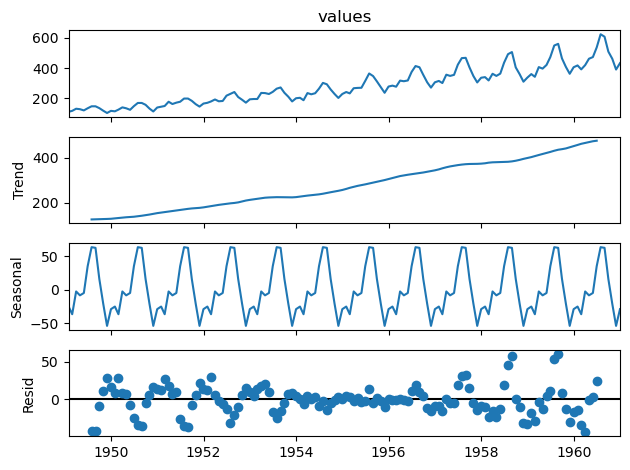

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
seasonal_decompose(series, model="additive", period=12).plot();

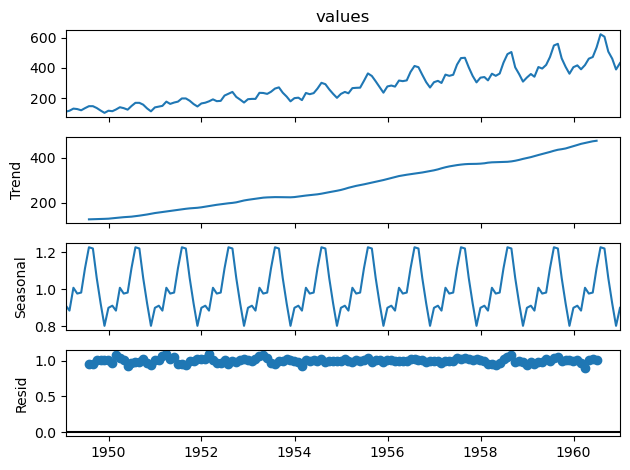

In [9]:
seasonal_decompose(series, model="multiplicative", period=12).plot();

## Variation playground: ETS

In [10]:
from modules import utils

df = df[['values']]

df_forecast = utils.get_model_forecast_exponential_smoothing(
    df, "values", horizon=96,
    class_config={"trend": "add", "seasonal": "mul", "seasonal_periods": 12},
    column_name='trend_add_seasonal_mul_12'
)
df_forecast = utils.get_model_forecast_exponential_smoothing(
    df_forecast, "values", horizon=96,
    class_config={"trend": "mul", "seasonal": "mul", "seasonal_periods": 12},
    column_name='trend_mul_seasonal_mul_12'
)
df_forecast = utils.get_model_forecast_exponential_smoothing(
    df_forecast, "values", horizon=96,
    class_config={"trend": "add", "seasonal": "add", "seasonal_periods": 12},
    column_name='trend_add_seasonal_add_12'
)
df_forecast = utils.get_model_forecast_exponential_smoothing(
    df_forecast, "values", horizon=96,
    column_name='baseline'
)

df_forecast.plot(color="variable")

/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning:

overflow encountered in matmul



## Variation playground: SARIMA vs Exponential Smoothing

In [11]:
import numpy as np

df = df[['values']].copy()

df_forecast = utils.get_model_forecast(df, "values", order=(12, 1, 1), horizon=96, forecast_exp=True)
df_forecast = utils.get_model_forecast(df_forecast, "values", order=(0, 1, 1), seasonal_order=(0, 1, 1, 12), horizon=96, forecast_exp=True)
df_forecast = utils.get_model_forecast_exponential_smoothing(
df_forecast, "values", horizon=96,
    class_config={"trend": "add", "seasonal": "mul", "seasonal_periods": 12},
)

df_forecast.plot(color="variable")

/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



## Diagnostics and assumptions

In [12]:
model = ExponentialSmoothing(
    df["values"],
    trend="add",
    seasonal="mul",
    seasonal_periods=12,
).fit()

In [13]:
residuals = model.resid
residuals

1949-01-31    0.587559
1949-02-28   -2.060598
                ...   
1960-11-30   -3.492447
1960-12-31   -0.349611
Freq: ME, Length: 144, dtype: float64

### Autocorrelation

#### Plot

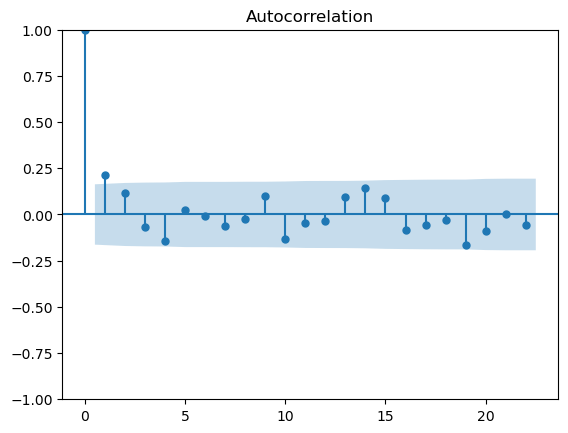

In [14]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals);

#### Test

In [15]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(residuals, lags=[10, 20, 30]).style

,lb_stat,lb_pvalue
10,17.347130,0.067027
20,31.854039,0.044879
30,43.886400,0.048836


### Normality

#### Plot

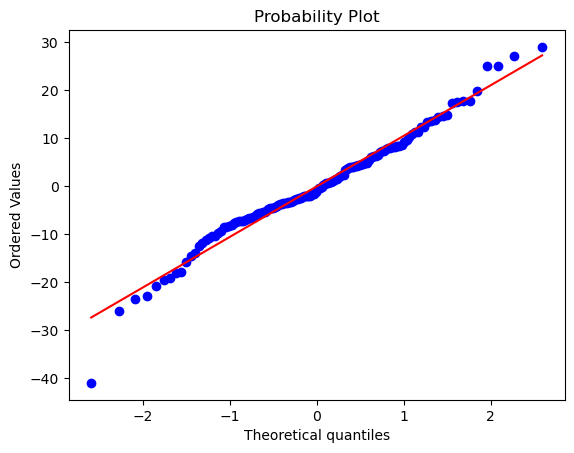

In [16]:
import matplotlib.pyplot as plt
from scipy import stats

fig, ax = plt.subplots()
stats.probplot(residuals, dist='norm', plot=ax);

#### Test

In [17]:
from scipy.stats import jarque_bera
jarque_bera(residuals)

SignificanceResult(statistic=np.float64(12.952211293727537), pvalue=np.float64(0.0015397955257427465))

### Homoscedasticity

#### Plot

In [18]:
residuals.plot()

#### Test

In [19]:
from statsmodels.stats.diagnostic import het_arch
het_arch(residuals)

(np.float64(10.685439095940257),
 np.float64(0.38254447409756054),
 1.06581818007948,
 0.3937205252485133)